In [299]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np

# Layer Norm by hand
- Fill in the Layer Norm application below. Make sure the manual and PyTorch implementations are the same.
- As before, FILL_IN the missing code to make this work.

In [2]:
FILL_IN = "FILL_IN"

In [60]:
# This is (N, T, d_model)
# N: batch size
# T: sentence_length
# d_model: embedding dimension

N, T, d_model = 2, 3, 4

# An embedding. This is what you might feed into a network.
embedding = torch.randn(N, T, d_model)

# Create a Layer Norm layer on the embedding dimension.
# Do not include gamma and beta, the learnable scaling and offset parameters.
# This should act of the dimenson of the model.
layer_norm =  nn.LayerNorm(d_model)
# Run embedding through the layer_norm layer.
layer_norm_pytorch = layer_norm(embedding)

# Manual computation; use the same EPSILON as is used in the standard nn.LayerNorm.
EPSILON = 1e-05

# Grab the mean of each vector in the first batch. This should be (3, 1).
mean = torch.mean(embedding[0], dim=1, keepdim=True)
# Grab the var of each vector in the first batch. This should be (3, 1).
var = torch.var(embedding[0], dim=1, keepdim=True, unbiased = False)
# this works too 
# var = torch.square(embedding[0] - mean).mean(dim=1, keepdim=True)
# # Manually take each vector in the batch and standerdize it.
layer_norm_manual = (embedding[0]-mean)/torch.sqrt(var+EPSILON)
print("layer_norm_manual @ 0: ", layer_norm_manual)
print("layer_norm_out[0]: ", layer_norm_pytorch[0])
assert torch.allclose(layer_norm_pytorch[0], layer_norm_manual), 'Tensors do not match.'

mean = torch.mean(embedding[1], dim=1, keepdim=True)
var = torch.var(embedding[1], dim=1, keepdim=True, unbiased = False)
layer_norm_manual = (embedding[1]-mean)/torch.sqrt(var+EPSILON)
print("layer_norm_manual @ 1: ", layer_norm_manual)
print("layer_norm_out[1]: ", layer_norm_pytorch[1])
assert torch.allclose(layer_norm_pytorch[1], layer_norm_manual), 'Tensors do not match.'

layer_norm_manual @ 0:  tensor([[-1.4096, -0.4234,  0.6395,  1.1935],
        [ 1.2675, -1.4911,  0.3810, -0.1574],
        [ 0.3662,  0.5476,  0.7978, -1.7116]])
layer_norm_out[0]:  tensor([[-1.4096, -0.4234,  0.6395,  1.1935],
        [ 1.2675, -1.4911,  0.3810, -0.1574],
        [ 0.3662,  0.5476,  0.7978, -1.7116]], grad_fn=<SelectBackward0>)
layer_norm_manual @ 1:  tensor([[-0.6540,  1.5835, -1.0271,  0.0976],
        [-0.8239,  1.1363,  0.8391, -1.1515],
        [-1.1349, -0.0566,  1.5955, -0.4039]])
layer_norm_out[1]:  tensor([[-0.6540,  1.5835, -1.0271,  0.0976],
        [-0.8239,  1.1363,  0.8391, -1.1515],
        [-1.1349, -0.0566,  1.5955, -0.4039]], grad_fn=<SelectBackward0>)


### Wave Net

In [106]:
# Hyperparameters we will use.                                                                                                                                                          
batch_size = 128 # How many independent sequences will we process in parallel?                                                                                              
context_size = 256 # What is the maximum context length for predictions? This is T below.                                                                                                    
epochs = 5000
eval_interval = 500
# Is this a good one? Can you check?
learning_rate = 3e-4
device = 'cpu' # 'mps' if torch.backends.mps.is_available() else 
eval_iters = 200
d_model = 20
d_hidden = 100
n_layer = 1
dropout = 0.2
write_to_file = False
norm = 'batch_norm'

# Add more pritning to the model.
debug = False
# ------------        

In [107]:
torch.manual_seed(1337)

# Load the Shakespere document input.txt.                                                                          
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [189]:
# Get all the unique characters in the text.                                                                                                             
chars = sorted(list(set(text)))
vocab_size = len(chars)
# As usual, create a mapping from a character to an int.                                                                                                                            
stoi = {char:i for i,char in enumerate(chars)}
itos = {i:char for char,i in stoi.items()}
# encode: is a lambda function that takes a string and returns  a list of ints, where each character is mapped to the right int.
encode = lambda x:[stoi[char] for char in x]
# decode: is the reverse mapping of encode. It takes a list of int, and returns a string.
decode =  lambda x:''.join([itos[ints] for ints in x])


In [190]:
# Do a train-test split with 90% of the data train and 10% test.
# You can just use the first 90% of the data as training data.
# Run the text through the encode method.
data = encode(text)
n = int(0.9*len(data)) # first 90% will be train, rest val                                                                                                                 
train_data = data[:n]
val_data = data[n+1:]


In [191]:
# Load the data.
# This should return a small batch of data (x, y) where x is 
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y.
    # Pick the train data if split == 'train', else the validation data.
    data = train_data if split =='train' else val_data
    # Select a random set of ints [0, len(data) - context_size) ; reshape this to be (batch_size, )
    # For an index i, a x should be data[i:i+context_size] while a y should be data[i+context_size].
    # ix has length batch_size.
    ix = torch.randint(len(data) - context_size, size=(batch_size,), dtype=torch.long)
    # Stack the batch_size data to be of shape (batch_size, context_size)
    x = torch.stack([torch.tensor(data[j:j+context_size]) for j in ix])
    # Stack the y targets; this should be of length batch_size.
    # You should pull out the i+context_size element of data; i is an index in ix.     
    y = torch.tensor([data[j+context_size] for j in ix]).view(-1,1)     
    x, y = x.to(device), y.to(device)
    return x, y

In [192]:
# Estimate the loss.

@torch.no_grad()
def estimate_loss():
    out = {}
    # Put the model in eval mode. Why? -> because we evaluate on train set and val set
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = model(xb, yb)
            # Get the value in the loss.
            losses[k] = loss.item()
        # Get the mean of the values in the losses.
        out[split] = torch.mean(losses).item()
    # Put the model in train mode.
    model.train()
    return out

In [287]:
class WaveNetMLPLanguageModel(nn.Module):

    def __init__(self,residual=False, layer_norm=False):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        
        self.linear_layers = []
        self.norm_layers = []
        self.scaling_matrix = []
        self.residual = residual
        self.layer_norm=layer_norm
        
        temp_context_size = context_size
        
        while temp_context_size >= 10:
            # Map from 2 * d_model to d_hidden.
            if not self.linear_layers:
                # Add to linear_layers a layer going 2 * d_model to d_hidden.
                self.linear_layers.append(nn.Linear(2*d_model,d_hidden))
            else:
                # Map from 2 * d_hidden to d_hidden.
                # Add to linear_layers a layer going 2 * d_hidden to d_hidden.
                self.linear_layers.append(nn.Linear(2*d_hidden,d_hidden))
            if self.residual:
                # scaling matrix
                self.scaling_matrix.append(nn.Linear(d_hidden, d_hidden, bias=False))
            # Append to norm_layers a batch norm 1d with vectors of size d_hidden.
            if self.layer_norm:
                self.norm_layers.append(nn.LayerNorm(d_hidden))
            else:
                self.norm_layers.append(nn.BatchNorm1d(num_features=d_hidden))
            
            temp_context_size //= 2
        
        # Add a final batch norm 1d with vectors of size vocab_size. 
        self.norm_f = nn.BatchNorm1d(num_features=vocab_size) # Final layer norm.
        # Add a Linear layer going from temp_context_size * d_hidden to vocab_size.
        self.ff = nn.Linear(temp_context_size * d_hidden, vocab_size)
        
    def forward(self, idx, targets=None):
        N, T = idx.shape

        # idx and targets are both (N, T) tensor of integers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
        x = self.token_embedding_table(idx) # (N, T, d_model)
        
        for i, _ in enumerate(self.linear_layers):
            N, T, D = x.shape
            # Reshape x to be (N, T//2,D*2). You want to shrink the context window down by two each time.
            x = x.view(N,-1,D*2)
            # Pass through linear layer i.
            x = self.linear_layers[i](x)
            # Transpose appropriate dimensions of x. Look at the expected dimensions of BatchNorm1d.
            x = x.view(-1,d_hidden)
            # Pass through the batch norm layer.
            x = self.norm_layers[i](x)
            # Transpose back to the previous dimensions.
            x = x.view(N,-1,d_hidden)
            # Pass through ReLU.
            if self.residual:
                x = torch.nn.functional.relu(x) + self.scaling_matrix[i](x)
            else:
                x = torch.nn.functional.relu(x)
        # Reshape.
        x = x.view(N, -1) # (N, [T // (2 ** len(self.linear_layers))] * d_model)
        # Apply dropout.
        x = torch.nn.functional.dropout(x, p=dropout, training=True)
        
        # Apply self.ff.
        x =  self.ff(x) # (N, vocab_size)
        
        # Apply batch norm -> even if we use layer norm, this is fine as we are not dealing with a third dimension 
        x = self.norm_f(x)

        # Apply Tanh.
        logits = torch.tanh(x)

        if targets is None:
            loss = None
        else:
            _, T = logits.shape

            assert(T == vocab_size)

            # Apply cross entropy.
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits,targets.view(-1))

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is a (N, T) array of indices in the current context.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
        for _ in range(max_new_tokens):
            # Here, we crop idx to the last context_size tokens.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
            idx_cond =  idx[:, -context_size:]
            # Get the predictions; this is just the last timestep.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
            logits, loss = model(idx_cond)
            # Apply softmax to get probabilities.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
            probs = torch.softmax(logits,dim=1) # (N, vocab_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
            # Sample from the distribution to get the next character's index.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            idx_next = torch.multinomial(probs,num_samples=1) # (N, 1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
            # Append sampled index to the running sequence.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            idx =  torch.cat([idx, idx_next], dim=1) # (N, T+1)
        return idx # At most, this is (N, T + max_new_tokens) in the second dimension.

Train the model.

In [307]:
model = WaveNetMLPLanguageModel().to(device)
# Print the number of parameters in the model.
print(sum(p.numel() for p in model.parameters()), 'parameters')

# Create a PyTorch optimizer. Use AdamW.                
learning_rate=0.001
optimizer = torch.optim.AdamW(params=model.parameters(),lr=learning_rate)

# grad 
log_interval_grad = 500
print_grads = True
print_parameters = False

53495 parameters


In [308]:
# Here we loop over max_iters and at each iter we get a batch of data we optimize over.
model.train()
x=[]
train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
    # every once in a while evaluate the loss on train and val sets                                                                                                                                                                                                 
    if epoch % eval_interval == 0 or epoch == epochs - 1:
        losses = estimate_loss()
        x.append(epoch)
        train_loss_list.append(losses['train'])
        val_loss_list.append(losses['val'])
        print(f"step {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
                
    # Sample a batch of data                                                                                                                                                                                                                                        
    xb, yb = get_batch('train')
    # evaluate the loss                                                                                                                                                                                                                                             
    logits, loss = model(xb, yb)
    # Zero the grads.
    optimizer.zero_grad()
    # Get gradients by backprop; do a parameter update.
    loss.backward()
    optimizer.step()
    
    if epoch % log_interval_grad == 0 and print_grads:
        param_scale = 0.0
        grad_scale = 0.0
        total_grads = 0
        zero_grads = 0

        for _, param in model.named_parameters():
            # .ravel() flattens a tensor.
            param_scale += np.linalg.norm(param.data.ravel())
            grad_scale += np.linalg.norm(learning_rate * param.grad.ravel())
            total_grads += len(param.grad.ravel())
            zero_grads += sum(param.grad.ravel() == 0.0).item()

            # Maybe you want to print some of the parameters?
            if print_parameters:
                print(param.grad.ravel())
                print(param.data.ravel())

        # Ideally, the ratio is around 0.001 or so.
        print("The ratio of data to grads is: {}".format(grad_scale / param_scale))
        # What percentage of parmaters have zero gradient?
        print("The percentage of zero grads is: {}".format(zero_grads / total_grads))

step 0: train loss 4.2530, val loss 4.2565
The ratio of data to grads is: 6.375965545145377e-05
The percentage of zero grads is: 0.0011402934853724648
step 500: train loss 3.8878, val loss 3.8995
The ratio of data to grads is: 3.493736719570529e-05
The percentage of zero grads is: 0.0011589868211982427
step 1000: train loss 3.6368, val loss 3.6533
The ratio of data to grads is: 1.7833435138556288e-05
The percentage of zero grads is: 0.0011216001495466866
step 1500: train loss 3.5579, val loss 3.5869
The ratio of data to grads is: 1.2285813047244066e-05
The percentage of zero grads is: 0.0007664267688569025
step 2000: train loss 3.5307, val loss 3.5622
The ratio of data to grads is: 9.663143659071601e-06
The percentage of zero grads is: 0.0003925600523413403
step 2500: train loss 3.5062, val loss 3.5355
The ratio of data to grads is: 8.545560256802401e-06
The percentage of zero grads is: 0.0007851201046826806
step 3000: train loss 3.4947, val loss 3.5282
The ratio of data to grads is: 7

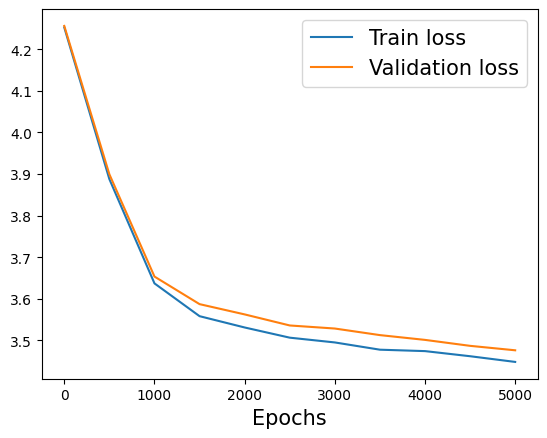

In [309]:
import matplotlib.pyplot as plt
plt.plot(x,train_loss_list)
plt.plot(x,val_loss_list)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
plt.xlabel('Epochs', size=15)
plt.show()

In [213]:
# Generate from the model and save it to wave_net.txt.
# We generate a maximum of 1000 tokens. 
# We feed in a batch of dimenson (1, context_size).
# The loss should get to ~ 2.0 on train and validation.
# Unfortunately, this will likely not make much sense, the capacity of this model is not ideal for this task.
# The name generation task from HW 1 might be aother data set to use.
model.eval()

context = torch.tensor(train_data)[:256].reshape(1, 256)
print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))
# if write_to_file:
#     open('wave_net.txt', 'w').write(decode(model.generate(context, max_new_tokens=10000)[0].tolist()))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
mJtnhnrsvSiF,
Or'mixaiidK Lxit,etoTs u? zm-ateRoiaohwQree! LtariotYuGhfehsdZeQltHkahYee m&oFn
O,kl i


Bonus (+5 max - If you do this and it's all right this assignment will be 13/10.)

Add some plots that show the train and validation loss, per k iterations. You might want k < 500

Comment : Done throughout the notebook

Add some residual connections. Does this improve gradient zero issues?

Add some logging to figure out the number of zero gradients across the network before and after you add the residual connections.

Comments: 
- I added the residual connections just like we defined in class: scaling matrix * input + the relu of the input.
- It did not improve the gradient issues as we can see in the log. We have in average a ratio of 0.001 of zero gradient for both. This is probably because we don't really have the issue of the vanishing gradient in our case. The ratio is pretty low already.

In [306]:
model = WaveNetMLPLanguageModel(residual=True).to(device)
# Print the number of parameters in the model.
print(sum(p.numel() for p in model.parameters()), 'parameters')

# Create a PyTorch optimizer. Use AdamW.                
learning_rate=0.001
optimizer = torch.optim.AdamW(params=model.parameters(),lr=learning_rate)

# grad 
log_interval_grad = 500
print_grads = True
print_parameters = False

# Here we loop over max_iters and at each iter we get a batch of data we optimize over.
model.train()
x=[]
train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
    # every once in a while evaluate the loss on train and val sets                                                                                                                                                                                                 
    if epoch % eval_interval == 0 or epoch == epochs - 1:
        losses = estimate_loss()
        x.append(epoch)
        train_loss_list.append(losses['train'])
        val_loss_list.append(losses['val'])
        print(f"step {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        
    # Sample a batch of data                                                                                                                                                                                                                                        
    xb, yb = get_batch('train')
    # evaluate the loss                                                                                                                                                                                                                                             
    logits, loss = model(xb, yb)
    # Zero the grads.
    optimizer.zero_grad()
    # Get gradients by backprop; do a parameter update.
    loss.backward()
    optimizer.step()
    
    if epoch % log_interval_grad == 0 and print_grads:
        param_scale = 0.0
        grad_scale = 0.0
        total_grads = 0
        zero_grads = 0

        for _, param in model.named_parameters():
            # .ravel() flattens a tensor.
            param_scale += np.linalg.norm(param.data.ravel())
            grad_scale += np.linalg.norm(learning_rate * param.grad.ravel())
            total_grads += len(param.grad.ravel())
            zero_grads += sum(param.grad.ravel() == 0.0).item()

            # Maybe you want to print some of the parameters?
            if print_parameters:
                print(param.grad.ravel())
                print(param.data.ravel())

        # Ideally, the ratio is around 0.001 or so.
        print("The ratio of data to grads is: {}".format(grad_scale / param_scale))
        # What percentage of parmaters have zero gradient?
        print("The percentage of zero grads is: {}".format(zero_grads / total_grads))
        

53495 parameters
step 0: train loss 4.2719, val loss 4.2678
The ratio of data to grads is: 6.40434884535619e-05
The percentage of zero grads is: 0.001177680157024021
step 500: train loss 3.8606, val loss 3.8738
The ratio of data to grads is: 3.2329675838550856e-05
The percentage of zero grads is: 0.0007664267688569025
step 1000: train loss 3.6229, val loss 3.6366
The ratio of data to grads is: 1.7768372744673665e-05
The percentage of zero grads is: 0.0011216001495466866
step 1500: train loss 3.5449, val loss 3.5671
The ratio of data to grads is: 1.1654447702690054e-05
The percentage of zero grads is: 0.0007664267688569025
step 2000: train loss 3.5074, val loss 3.5317
The ratio of data to grads is: 9.130384953097635e-06
The percentage of zero grads is: 0.0007664267688569025
step 2500: train loss 3.4852, val loss 3.5120
The ratio of data to grads is: 8.64703181292386e-06
The percentage of zero grads is: 0.0008225067763342369
step 3000: train loss 3.4728, val loss 3.4826
The ratio of data

In [ ]:
plt.plot(x,train_loss_list)
plt.plot(x,val_loss_list)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
plt.xlabel('Epochs', size=15)
plt.show()

Use LayerNorm instead of batch norm.

Comments: Performance is slightly better with layer norm (3.46 vs 3.48 in val loss). The difference in val loss is so low that i don't think that layer norm add is better than batch norm in this case. 

In [288]:
model = WaveNetMLPLanguageModel(layer_norm=True).to(device)
# Print the number of parameters in the model.
print(sum(p.numel() for p in model.parameters()), 'parameters')

# Create a PyTorch optimizer. Use AdamW.                
learning_rate=0.001
optimizer = torch.optim.AdamW(params=model.parameters(),lr=learning_rate)

# Here we loop over max_iters and at each iter we get a batch of data we optimize over.
model.train()
x=[]
train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
    # every once in a while evaluate the loss on train and val sets                                                                                                                                                                                                 
    if epoch % eval_interval == 0 or epoch == epochs - 1:
        losses = estimate_loss()
        x.append(epoch)
        train_loss_list.append(losses['train'])
        val_loss_list.append(losses['val'])
        print(f"step {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    # Sample a batch of data                                                                                                                                                                                                                                        
    xb, yb = get_batch('train')
    # evaluate the loss                                                                                                                                                                                                                                             
    logits, loss = model(xb, yb)
    # Zero the grads.
    optimizer.zero_grad()
    # Get gradients by backprop; do a parameter update.
    loss.backward()
    optimizer.step()

53495 parameters
step 0: train loss 4.2097, val loss 4.2139
step 500: train loss 3.8812, val loss 3.8991
step 1000: train loss 3.6310, val loss 3.6562
step 1500: train loss 3.5556, val loss 3.5808
step 2000: train loss 3.5248, val loss 3.5506
step 2500: train loss 3.5012, val loss 3.5298
step 3000: train loss 3.4864, val loss 3.5205
step 3500: train loss 3.4716, val loss 3.5052
step 4000: train loss 3.4714, val loss 3.4851
step 4500: train loss 3.4513, val loss 3.4827
step 4999: train loss 3.4467, val loss 3.4620


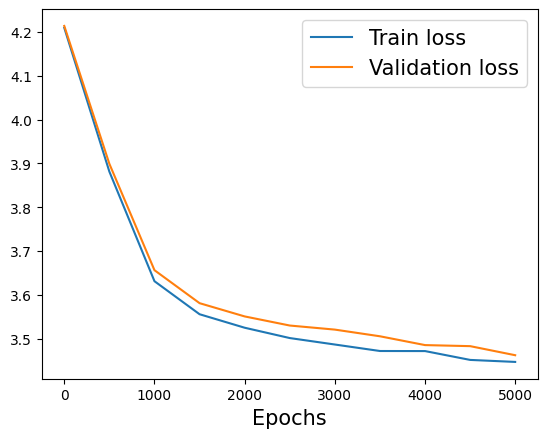

In [289]:
plt.plot(x,train_loss_list)
plt.plot(x,val_loss_list)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
plt.xlabel('Epochs', size=15)
plt.show()

Use the names.txt file from assignment 1. How do the names look?

Comments: The names does not make any sense just like previously.

In [290]:
# Load the name names.txt.                                                                          
with open('names.txt', 'r', encoding='utf-8') as f:
    names_text = f.read()
names_data = encode(names_text)

In [297]:
# The name generation
# we use the basic model without residual or layer norm 
model.eval()
context = torch.tensor(names_data)[:256].reshape(1, 256)
print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))
if write_to_file:
    open('wave_net_names.txt', 'w').write(decode(model.generate(context, max_new_tokens=10000)[0].tolist()))

emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn
abigail
emily
elizabeth
mila
ella
avery
sofia
camila
aria
scarlett
victoria
madison
luna
grace
chloe
penelope
layla
riley
zoey
nora
lily
eleanor
hannah
lillian
addison
aubrey
ellie
stella
noalcnimksboat R:Yasn-,K,qsoH:.tv,lyligdw
i!iAi.&:ta!tMrtLTlsnooskV.vcsAHacaitakxStKVdsVrwavu JkwQE r
